# Imports

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

In [7]:
path = "Paper_Data/PartB_PLOS_ONE_2015_biofeatures/Table_Step2_159Features-85Subs-5Levels-z.csv"

tabular_data = pd.read_csv(path)

In [8]:
def load_signal(file_path, delimiter = '\t'):
    """
   Load raw signal data from a CSV file with custom delimiters.

   Args:
   - file_path (str): The path to the CSV file.
   - delimiter (str, optional): The delimiter used in the CSV file (default is '\t' for tab-delimited).

   Returns:
   - pd.DataFrame: A DataFrame containing the raw signal data.
   """
    try:
        raw_signal_data = pd.read_csv(file_path, delimiter=delimiter)
        return raw_signal_data
    except FileNotFoundError:
        print(f"File not found at path: {file_path}")
        return None

In [12]:
# Initialize an empty list to store the data
data = []

directory_path = "PartB/biosignals_filtered/biosignals_filtered"

for candidate in os.listdir(directory_path):
    folder_path = os.path.join(directory_path, candidate)
    # Iterate through all files in the directory
    for filename in os.listdir(folder_path):
        if filename.endswith("_bio.csv"):
            # Extract information from the filename
            parts = filename.split('-')
            age = int(parts[0][-2:])  # Extract age (e.g., 21)
            gender = parts[0][-3]    # Extract gender (e.g., 'w' for woman)
            
            # Determine the pain level based on the filename
            if "BL" in filename:
                pain_level = 0  # Assign pain level 0 for baseline
            else:
                pain_level = int(parts[1][2:])  # Extract pain level (e.g., 2)
    
            # Read the CSV file and store it in a DataFrame
            file_path = os.path.join(folder_path, filename)
            df = load_signal(file_path)
    
            # Append the data to the list
            data.append({
                'age': age,
                'candidate': candidate,
                'gender': gender,
                'pain_level': pain_level,
                'ecg': df['ecg'],
                'gsr': df['gsr']
            })

# Preprocessing

In [15]:
# Extract all ECG and GSR data into single arrays
ecg_data = np.concatenate([entry['ecg'] for entry in data])
gsr_data = np.concatenate([entry['gsr'] for entry in data])

# Reshape the data
ecg_data_reshaped = ecg_data.reshape(-1, 1)
gsr_data_reshaped = gsr_data.reshape(-1, 1)

# Create a Min-Max scaler and fit it to the entire ECG and GSR datasets
ecg_scaler = MinMaxScaler()
gsr_scaler = MinMaxScaler()

ecg_scaler.fit(ecg_data_reshaped)
gsr_scaler.fit(gsr_data_reshaped)

# Initialize empty lists for X and y
X = []
y = []

# Create X and y by iterating through data
for entry in data:
    normalized_ecg = ecg_scaler.transform(entry['ecg'].to_numpy().reshape(-1, 1))
    normalized_gsr = gsr_scaler.transform(entry['gsr'].to_numpy().reshape(-1, 1))

    # Concatenating normalized ECG and GSR data horizontally and appending to X
    X.append(np.hstack((normalized_ecg, normalized_gsr)))

    # Appending pain_level to y
    y.append(entry['pain_level'])

# Convert lists to NumPy arrays for ML modeling
X = np.array(X)
y = np.array(y)

In [18]:
print(X.shape)
print(y.shape)

(8600, 2816, 2)
(8600,)


In [20]:
y_categorical = to_categorical(y)  # Convert integers to one-hot encoded labels

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [22]:
print(y_categorical.shape)
print(X_train.shape)

(8600, 5)
(6880, 2816, 2)


# Traditional ML

In [23]:
X_fft = []

for sample in X:
    ecg_fft = np.abs(np.fft.fft(sample[:, 0]))
    gsr_fft = np.abs(np.fft.fft(sample[:, 1]))

    X_fft.append(np.hstack((ecg_fft, gsr_fft)))

X_fft = np.array(X_fft)

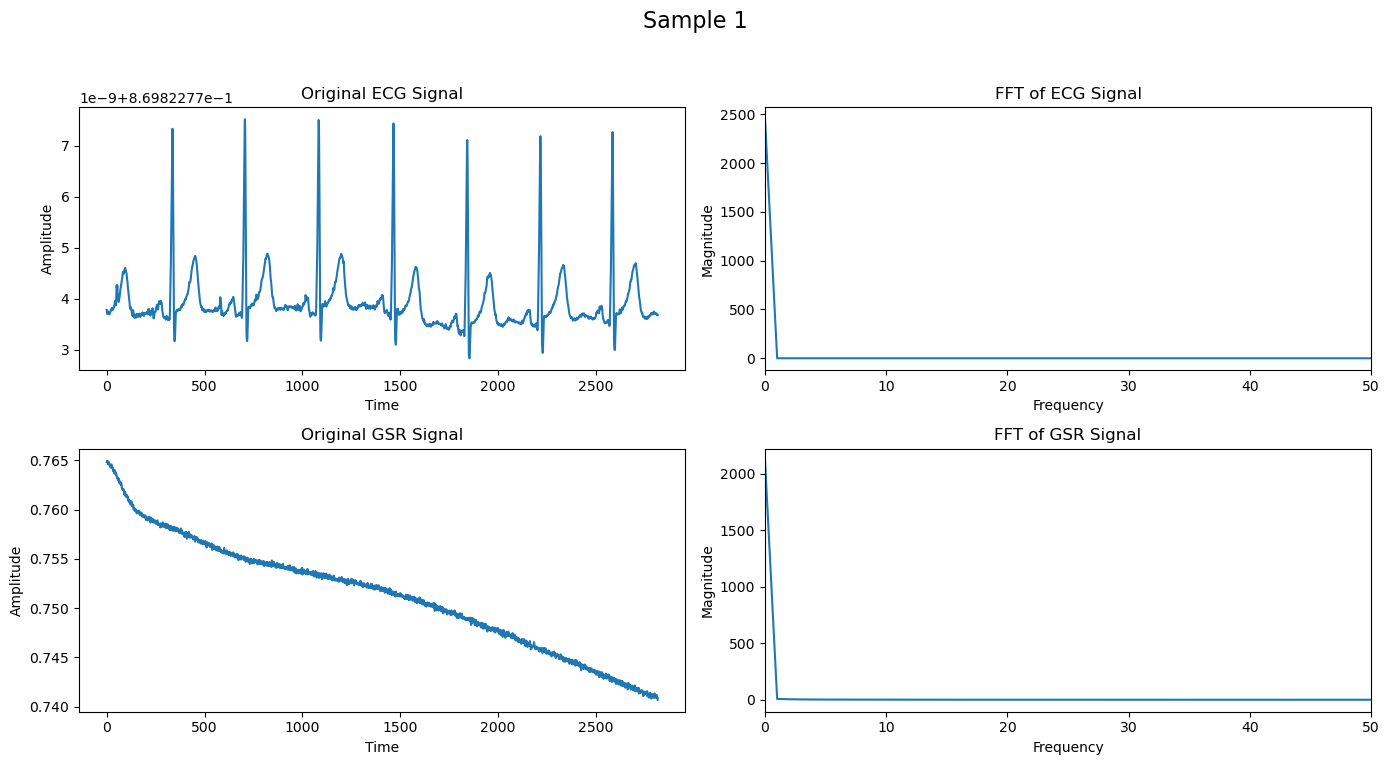

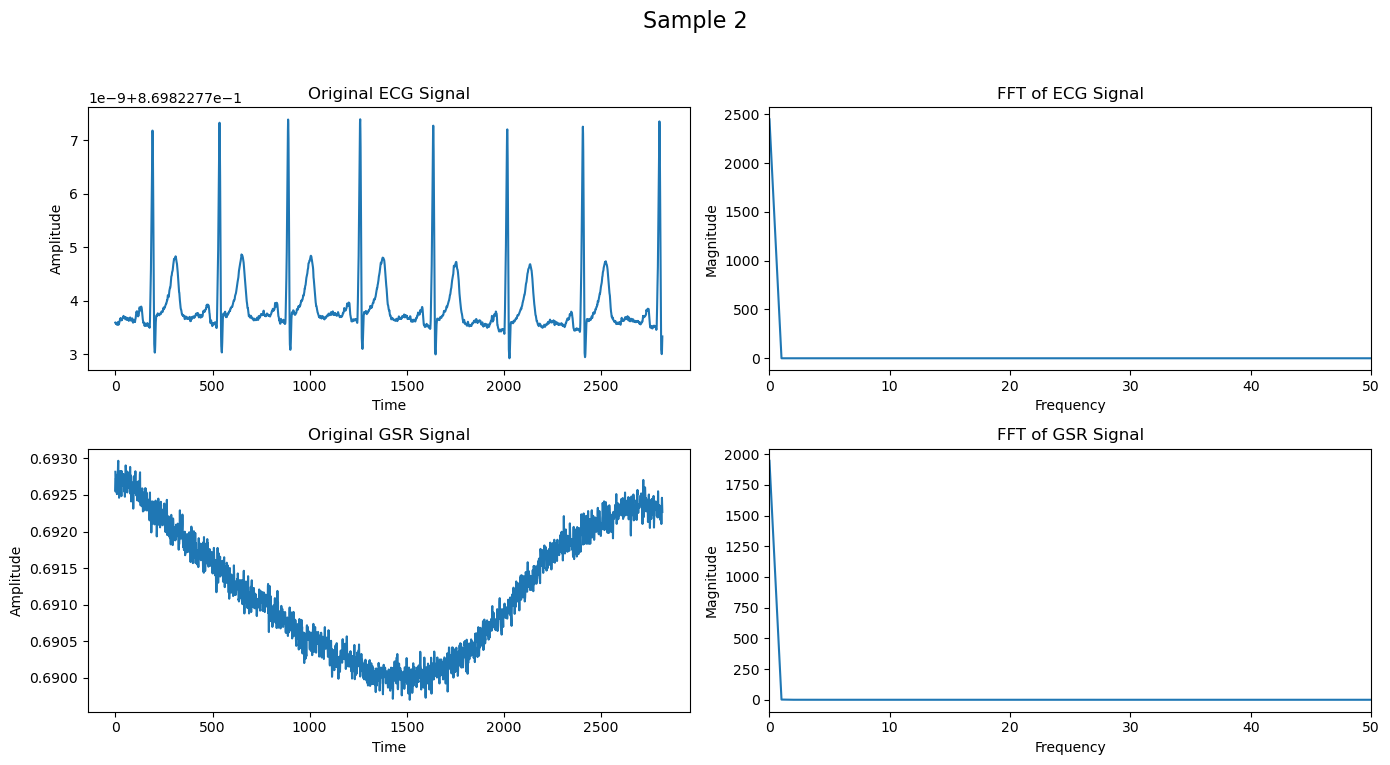

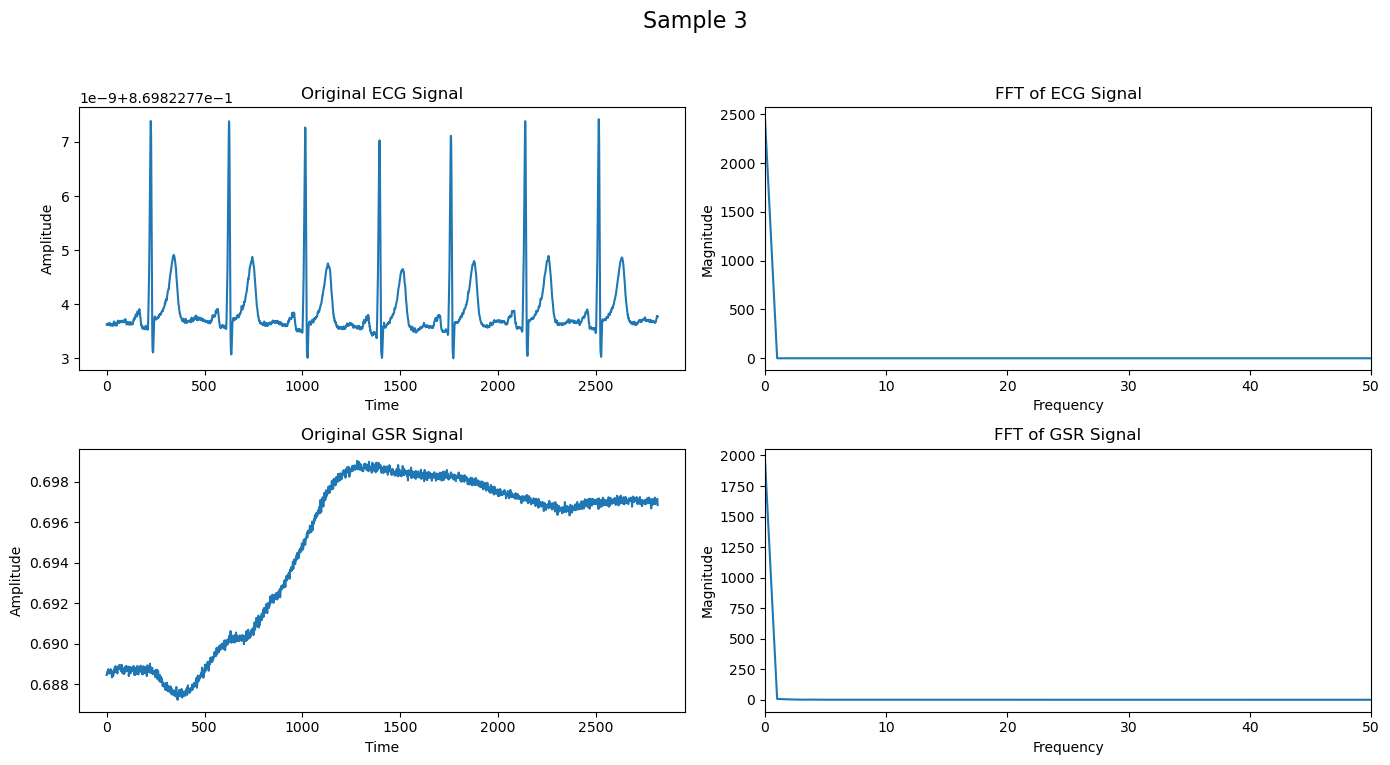

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Select a few samples to plot
num_samples_to_plot = 3

for i in range(num_samples_to_plot):
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle(f'Sample {i+1}', fontsize=16)

    # Original ECG Signal
    axs[0, 0].plot(X[i, :, 0])
    axs[0, 0].set_title('Original ECG Signal')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel('Amplitude')

    # FFT of ECG Signal
    ecg_fft = np.abs(np.fft.fft(X[i, :, 0]))
    axs[0, 1].plot(ecg_fft)
    axs[0, 1].set_title('FFT of ECG Signal')
    axs[0, 1].set_xlabel('Frequency')
    axs[0, 1].set_ylabel('Magnitude')
    axs[0, 1].set_xlim([0, 50])  # Set x-axis limit

    # Original GSR Signal
    axs[1, 0].plot(X[i, :, 1])
    axs[1, 0].set_title('Original GSR Signal')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Amplitude')

    # FFT of GSR Signal
    gsr_fft = np.abs(np.fft.fft(X[i, :, 1]))
    axs[1, 1].plot(gsr_fft)
    axs[1, 1].set_title('FFT of GSR Signal')
    axs[1, 1].set_xlabel('Frequency')
    axs[1, 1].set_ylabel('Magnitude')
    axs[1, 1].set_xlim([0, 50])  # Set x-axis limit

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# LSTM

# Transformer

In [7]:
from scipy import signal

# Define the original and target sampling frequencies
original_fs = 704.0  # Original sampling frequency (Hz)
target_fs = 128.0   # Target sampling frequency (Hz)

# Calculate the resampling factor
resampling_factor = target_fs / original_fs

# Resample the ECG signals in X_train
X_train_resampled = []
for entry in X_train:
    resampled_signal = signal.resample(entry, int(len(entry) * resampling_factor))
    X_train_resampled.append(resampled_signal)

# Resample the ECG signals in X_test
X_test_resampled = []
for entry in X_test:
    resampled_signal = signal.resample(entry, int(len(entry) * resampling_factor))
    X_test_resampled.append(resampled_signal)

# Convert the resampled data to NumPy arrays
X_train_resampled = np.array(X_train_resampled)
X_test_resampled = np.array(X_test_resampled)

In [8]:
# Quantization of ECG data
num_bins = 50  # Define the number of bins you'd like to use

# Initialize KBinsDiscretizer
kbin = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='uniform')
kbin.fit(np.concatenate((X_test_resampled, X_test_resampled)))

X_train_tokenized = kbin.transform(X_train_resampled)
X_test_tokenized = kbin.transform(X_test_resampled)

/home/davidokel/miniconda3/envs/new_tf_gpu_env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader, TensorDataset

# Initialize a pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

# Define a custom classifier model
class ECGClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ECGClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(768, num_classes)  # BERT hidden size is 768

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

# Convert tokenized data to PyTorch tensors
X_train_tokenized = torch.LongTensor(X_train_tokenized)
X_test_tokenized = torch.LongTensor(X_test_tokenized)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Create DataLoader for training and testing data
train_data = TensorDataset(X_train_tokenized, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_data = TensorDataset(X_test_tokenized, y_test)
test_loader = DataLoader(test_data, batch_size=32)

# Initialize the model
model = ECGClassifier(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, labels = batch
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask=(input_ids != 0))  # Attention mask for BERT
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids, labels = batch
        logits = model(input_ids, attention_mask=(input_ids != 0))
        predicted = torch.argmax(logits, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.2%}")
